In [60]:
import osmnx as ox
import folium
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopy.distance

In [2]:
def extract_munich_graph():
    # Define the place
    place = "Munich, Germany"

    # Extract the graph for the specified place
    graph = ox.graph_from_place(place, network_type='all')

    # Save the graph to a file or process it further
    # For example, to save as GraphML
    ox.save_graphml(graph, filepath="data/munich_street_network.graphml")

    return graph

def extract_closeup_munich_graph(bbox):
    graph = ox.graph_from_bbox(bbox[0], bbox[2], bbox[1], bbox[3], network_type='drive', simplify=True)
    ox.save_graphml(graph, filepath="data/munich_closeup_street_network.graphml")
    return graph

def read_munich_map():
    graph = ox.load_graphml("../data/munich_street_network.graphml")
    return graph

# Extract and process the graph
# munich_graph = read_munich_map()

bbox = [48.178301, 11.479089, 48.126705, 11.585432]

munich_graph = extract_closeup_munich_graph(bbox)
print("Number of nodes:", munich_graph.number_of_nodes())
print("Number of edges:", munich_graph.number_of_edges())

Number of nodes: 3010
Number of edges: 7419


Number of accidents: 1703


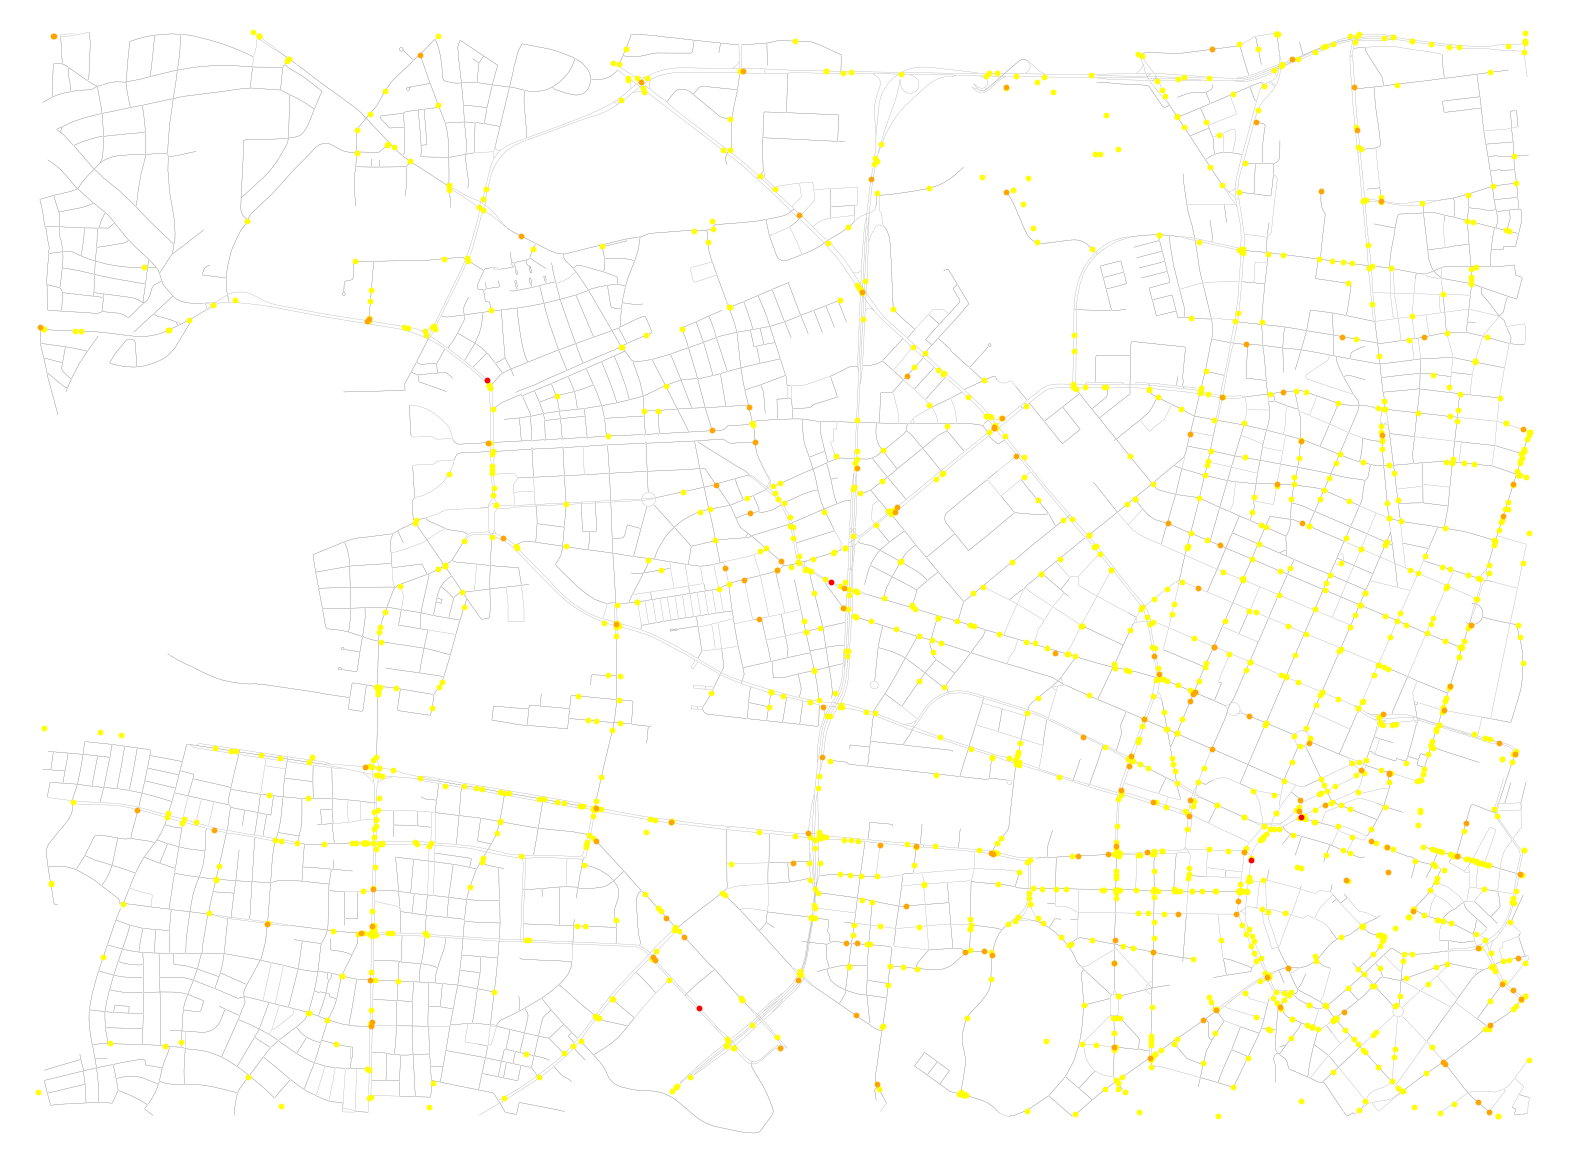

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig, ax = ox.plot.plot_graph(munich_graph, node_size=0.4, edge_linewidth=0.2,ax = ax, show=False, close=False)

color_map = ['red','orange','yellow']

accident_coords_low = pd.read_csv("../data/accidents_low.csv")
accident_coords_medium = pd.read_csv("../data/accidents_medium.csv")
accident_coords_high = pd.read_csv("../data/accidents_high.csv")

accident_coords = pd.concat([accident_coords_low, accident_coords_medium, accident_coords_high])
accident_coords = accident_coords[accident_coords['YGCSWGS84'] < bbox[0]]
accident_coords = accident_coords[accident_coords['YGCSWGS84'] > bbox[2]]
accident_coords = accident_coords[accident_coords['XGCSWGS84'] > bbox[1]]
accident_coords = accident_coords[accident_coords['XGCSWGS84'] < bbox[3]]

print("Number of accidents:", accident_coords.shape[0])
#plot point of interest
for index, row in accident_coords.iterrows():
    ax.scatter(row['XGCSWGS84'],row['YGCSWGS84'], c=color_map[int(row['UKATEGORIE'])-1], s=10,zorder=3)


In [63]:

def nodes_within_distance(graph,coords, distance_threshold):
    """
    Find all nodes within a certain Euclidean distance of a specified node.

    :param graph: The graph containing the nodes.
    :param node_id: The ID of the specified node.
    :param distance_threshold: The distance threshold.
    :return: A list of node IDs within the specified distance.
    """
    nodes_within_dist = []
    # Get the (latitude, longitude) of the specified node

    for node in graph.nodes:
        node_coords = (graph.nodes[node]['y'], graph.nodes[node]['x'])
        dist = geopy.distance.geodesic(coords, node_coords)
        if dist <= distance_threshold:
            nodes_within_dist.append(node)

    return nodes_within_dist

def assign_accidents_to_nodes(graph, accident_coords,dist_inter=10):
    # Initialize all nodes with 'num_accidents' attribute set to 0
    for node in graph.nodes:
        graph.nodes[node]['num_accidents'] = 0

    for edge in graph.edges:
        graph.edges[edge]['num_accidents'] = 0

    for index, row in accident_coords.iterrows():
        # Find the nearest nodes to each accident coordinate
        n_assigned_nodes = 0
        coords = (row['XGCSWGS84'], row['YGCSWGS84'])
        for node in graph.nodes:
            node_coords = (graph.nodes[node]['y'], graph.nodes[node]['x'])
            dist = geopy.distance.geodesic(coords, node_coords)

            if dist <= dist_inter:
                graph.nodes[node]['num_accidents'] += 1
                n_assigned_nodes += 1

        if n_assigned_nodes == 0:
            nearest_edge,dist = ox.nearest_edges(graph, X=coords[0], Y=coords[1], return_dist=True)
            if dist < 10:
                graph.edges[nearest_edge]['num_accidents'] += 1

    return graph


# Assign the accident counts to the nodes
munich_graph_accident = assign_accidents_to_nodes(munich_graph, accident_coords, dist_inter=10)
# munich_graph_accident_5 = assign_accidents_to_nodes(munich_graph, accident_coords, dist_inter=5)
# ox.save_graphml(munich_graph_accident, filepath="data/munich_street_network_accident.graphml")
# munich_graph_accident = ox.load_graphml("data/munich_street_network_accident.graphml")

for node in munich_graph_accident.nodes:
    munich_graph_accident.nodes[node]['num_accidents'] = int(munich_graph_accident.nodes[node]['num_accidents'])
    
for edge in munich_graph_accident.edges:
    munich_graph_accident.edges[edge]['num_accidents'] = int(munich_graph_accident.edges[edge]['num_accidents'])

In [284]:
nodes[route_nodes[100]]['num_accidents']

0

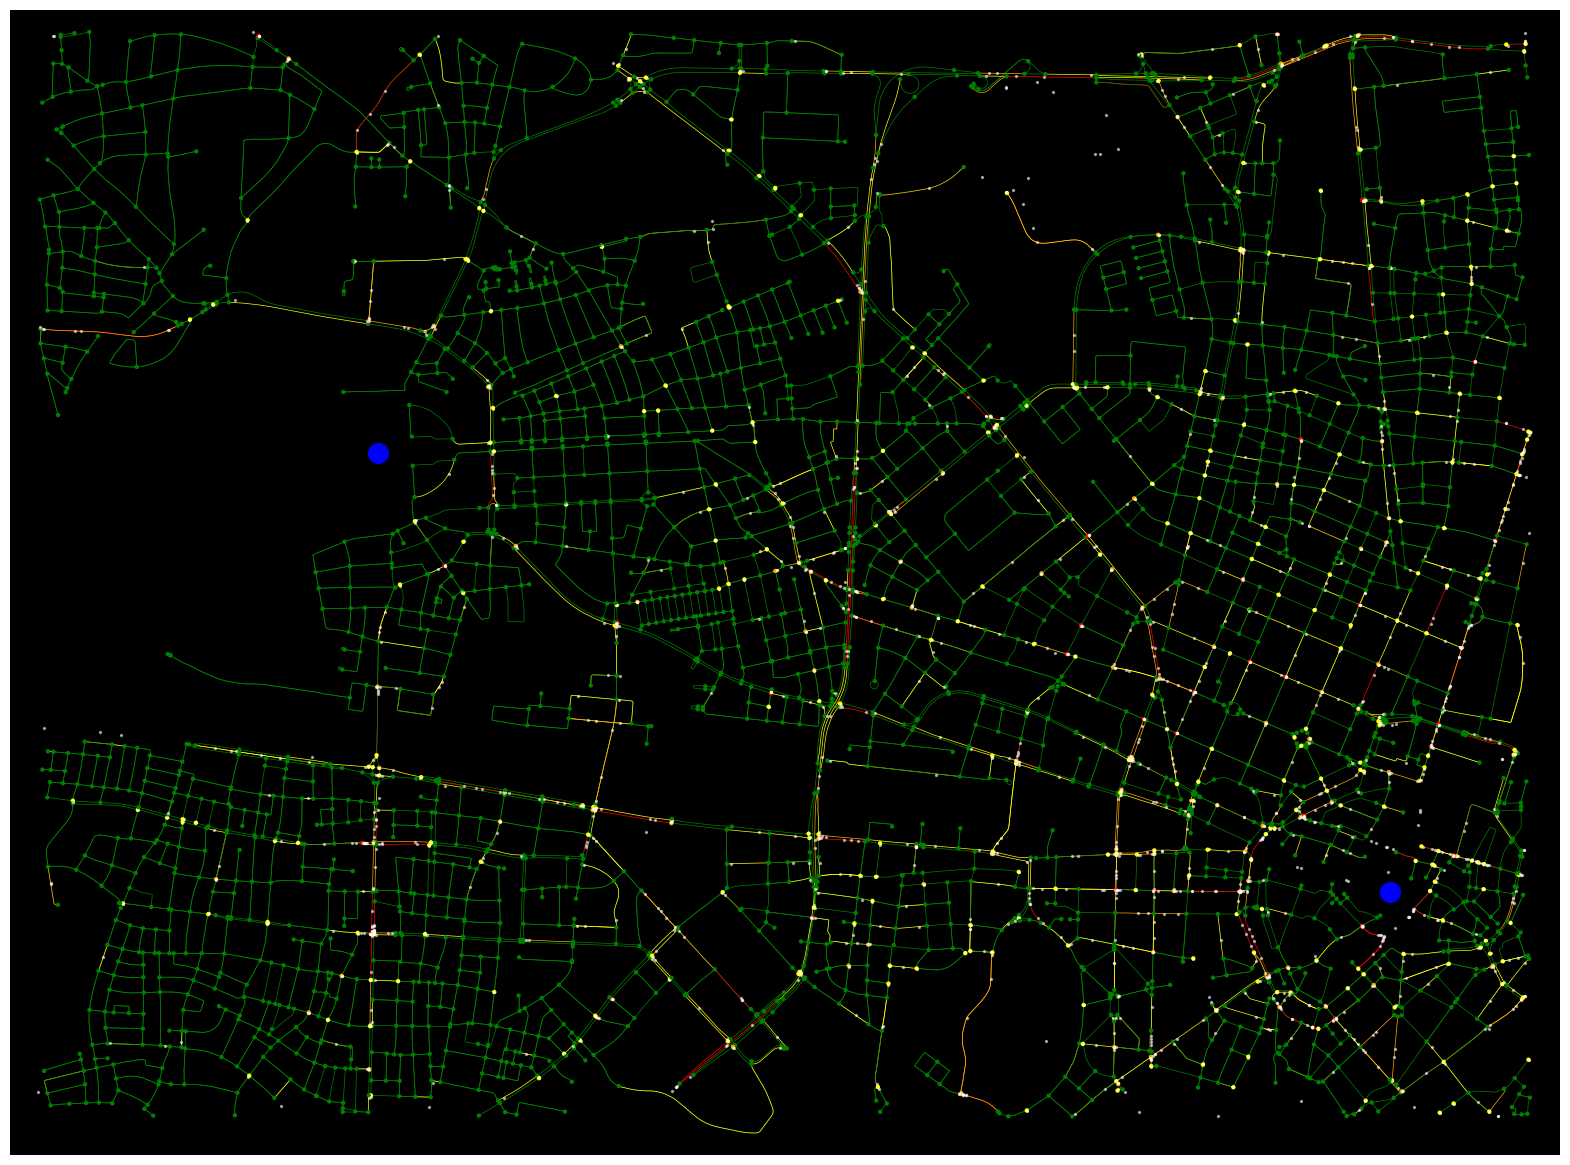

In [15]:
def get_colors_by_accidents(graph):
    node_colors = []
    edge_colors = []

    for node, data in graph.nodes(data=True):
        num_accidents = int(data.get('num_accidents', 0))

        if num_accidents == 0:
            color = 'green'  # No accidents
        elif num_accidents <= 1:
            color = 'yellow'  # Few accidents
        elif num_accidents <= 2:
            color = 'orange'  # Moderate accidents
        else:
            color = 'red'  # Many accidents
        node_colors.append(color)
    for u, v, data in graph.edges(data=True):
        num_accidents = data.get('num_accidents', 0)
        if num_accidents == 0:
            color = 'green'
        elif num_accidents <= 1:
            color = 'yellow'
        elif num_accidents <= 2:
            color = 'orange'
        else:
            color = 'red'
        edge_colors.append(color)
    return node_colors, edge_colors
    
# Assuming 'graph' is already processed with accident data
# graph = assign_accidents_to_nodes(graph, accident_coords)

# Get the node colors based on the number of accidents
node_colors, edge_colors = get_colors_by_accidents(munich_graph_accident)

# Plot the graph
# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# fig, ax = ox.plot.plot_graph(munich_graph_accident, node_color=node_colors, node_size=0.4, edge_linewidth=0.2,ax = ax, show=False, close=False)

fig, ax = ox.plot_graph(munich_graph_accident, node_color=node_colors, edge_color=edge_colors,figsize=(20, 20), node_size=10, edge_linewidth=0.5, show=False, close=False,bgcolor='black')
ax.scatter(accident_coords['XGCSWGS84'],accident_coords['YGCSWGS84'], c="white", s=2,zorder=3, alpha=0.5)
fig.savefig('munich_accident.png', dpi=300)

# Plot departure and arrival points
marienplatz = (11.575448,48.137393)
nympenburg = (11.503314,48.158268)
ax.scatter(marienplatz[0],marienplatz[1], c="blue", s=200,zorder=3)
ax.scatter(nympenburg[0],nympenburg[1], c="blue", s=200,zorder=3)



In [16]:
from openrouteservice import client
from hackaton_directions import *

api_key = '5b3ce3597851110001cf6248f542525fba9142fda869c4da4b458f4b'  # Individual api key
ors = client.Client(key=api_key)  # Create client with api key

centerpoint = ((marienplatz[1]+nympenburg[1])/2,(marienplatz[0]+nympenburg[0])/2)

map_params = {'tiles': 'OpenStreetMap',
              'location': centerpoint,
              'zoom_start': 13.5}



map = folium.Map(**map_params)
route, summary = driving_directions(ors, marienplatz, nympenburg)

folium.PolyLine(locations=[(y, x) for x, y in route], 
                name='Route without construction sites',
                color='#FF0000',
                weight = 4,
                overlay=True).add_to(map)

map 

In [28]:
def route_to_graph_node(route):
    nodes = []
    for coord in route:
        nodes.append(ox.nearest_nodes(munich_graph_accident, X=coord[1], Y=coord[0]))
        # graph.neighbors(start_node)
    return nodes
    

def number_of_accidents(route_nodes):
    num_accidents = 0
    for i,node in enumerate(route_nodes):
        num_accidents += munich_graph_accident.nodes[node]['num_accidents']
        # if 0 < i < len(route_nodes)-1:
                # num_accidents += munich_graph_accident[route_nodes[i-1]][route_nodes[i]][0]['num_accidents']
    return num_accidents

def edges_from_route(route_nodes):
    edges = []
    for i,node in enumerate(route_nodes):
        if 0 < i < len(route_nodes)-1:
                edges.append((route_nodes[i-1],route_nodes[i]))
    return edges

route_nodes = route_to_graph_node(route)

route_edges = list(zip(route_nodes[:-1], route_nodes[1:]))
edge_colors = ['red' if (u, v) in route_edges or (v, u) in route_edges else 'black' for u, v, k in munich_graph_accident.edges(keys=True)]

node_colors = ['red' if node in route_nodes else 'black' for node in munich_graph_accident.nodes()]
num_accidents = number_of_accidents(route_nodes)
print("Number of accidents:", num_accidents)

Number of accidents: 0


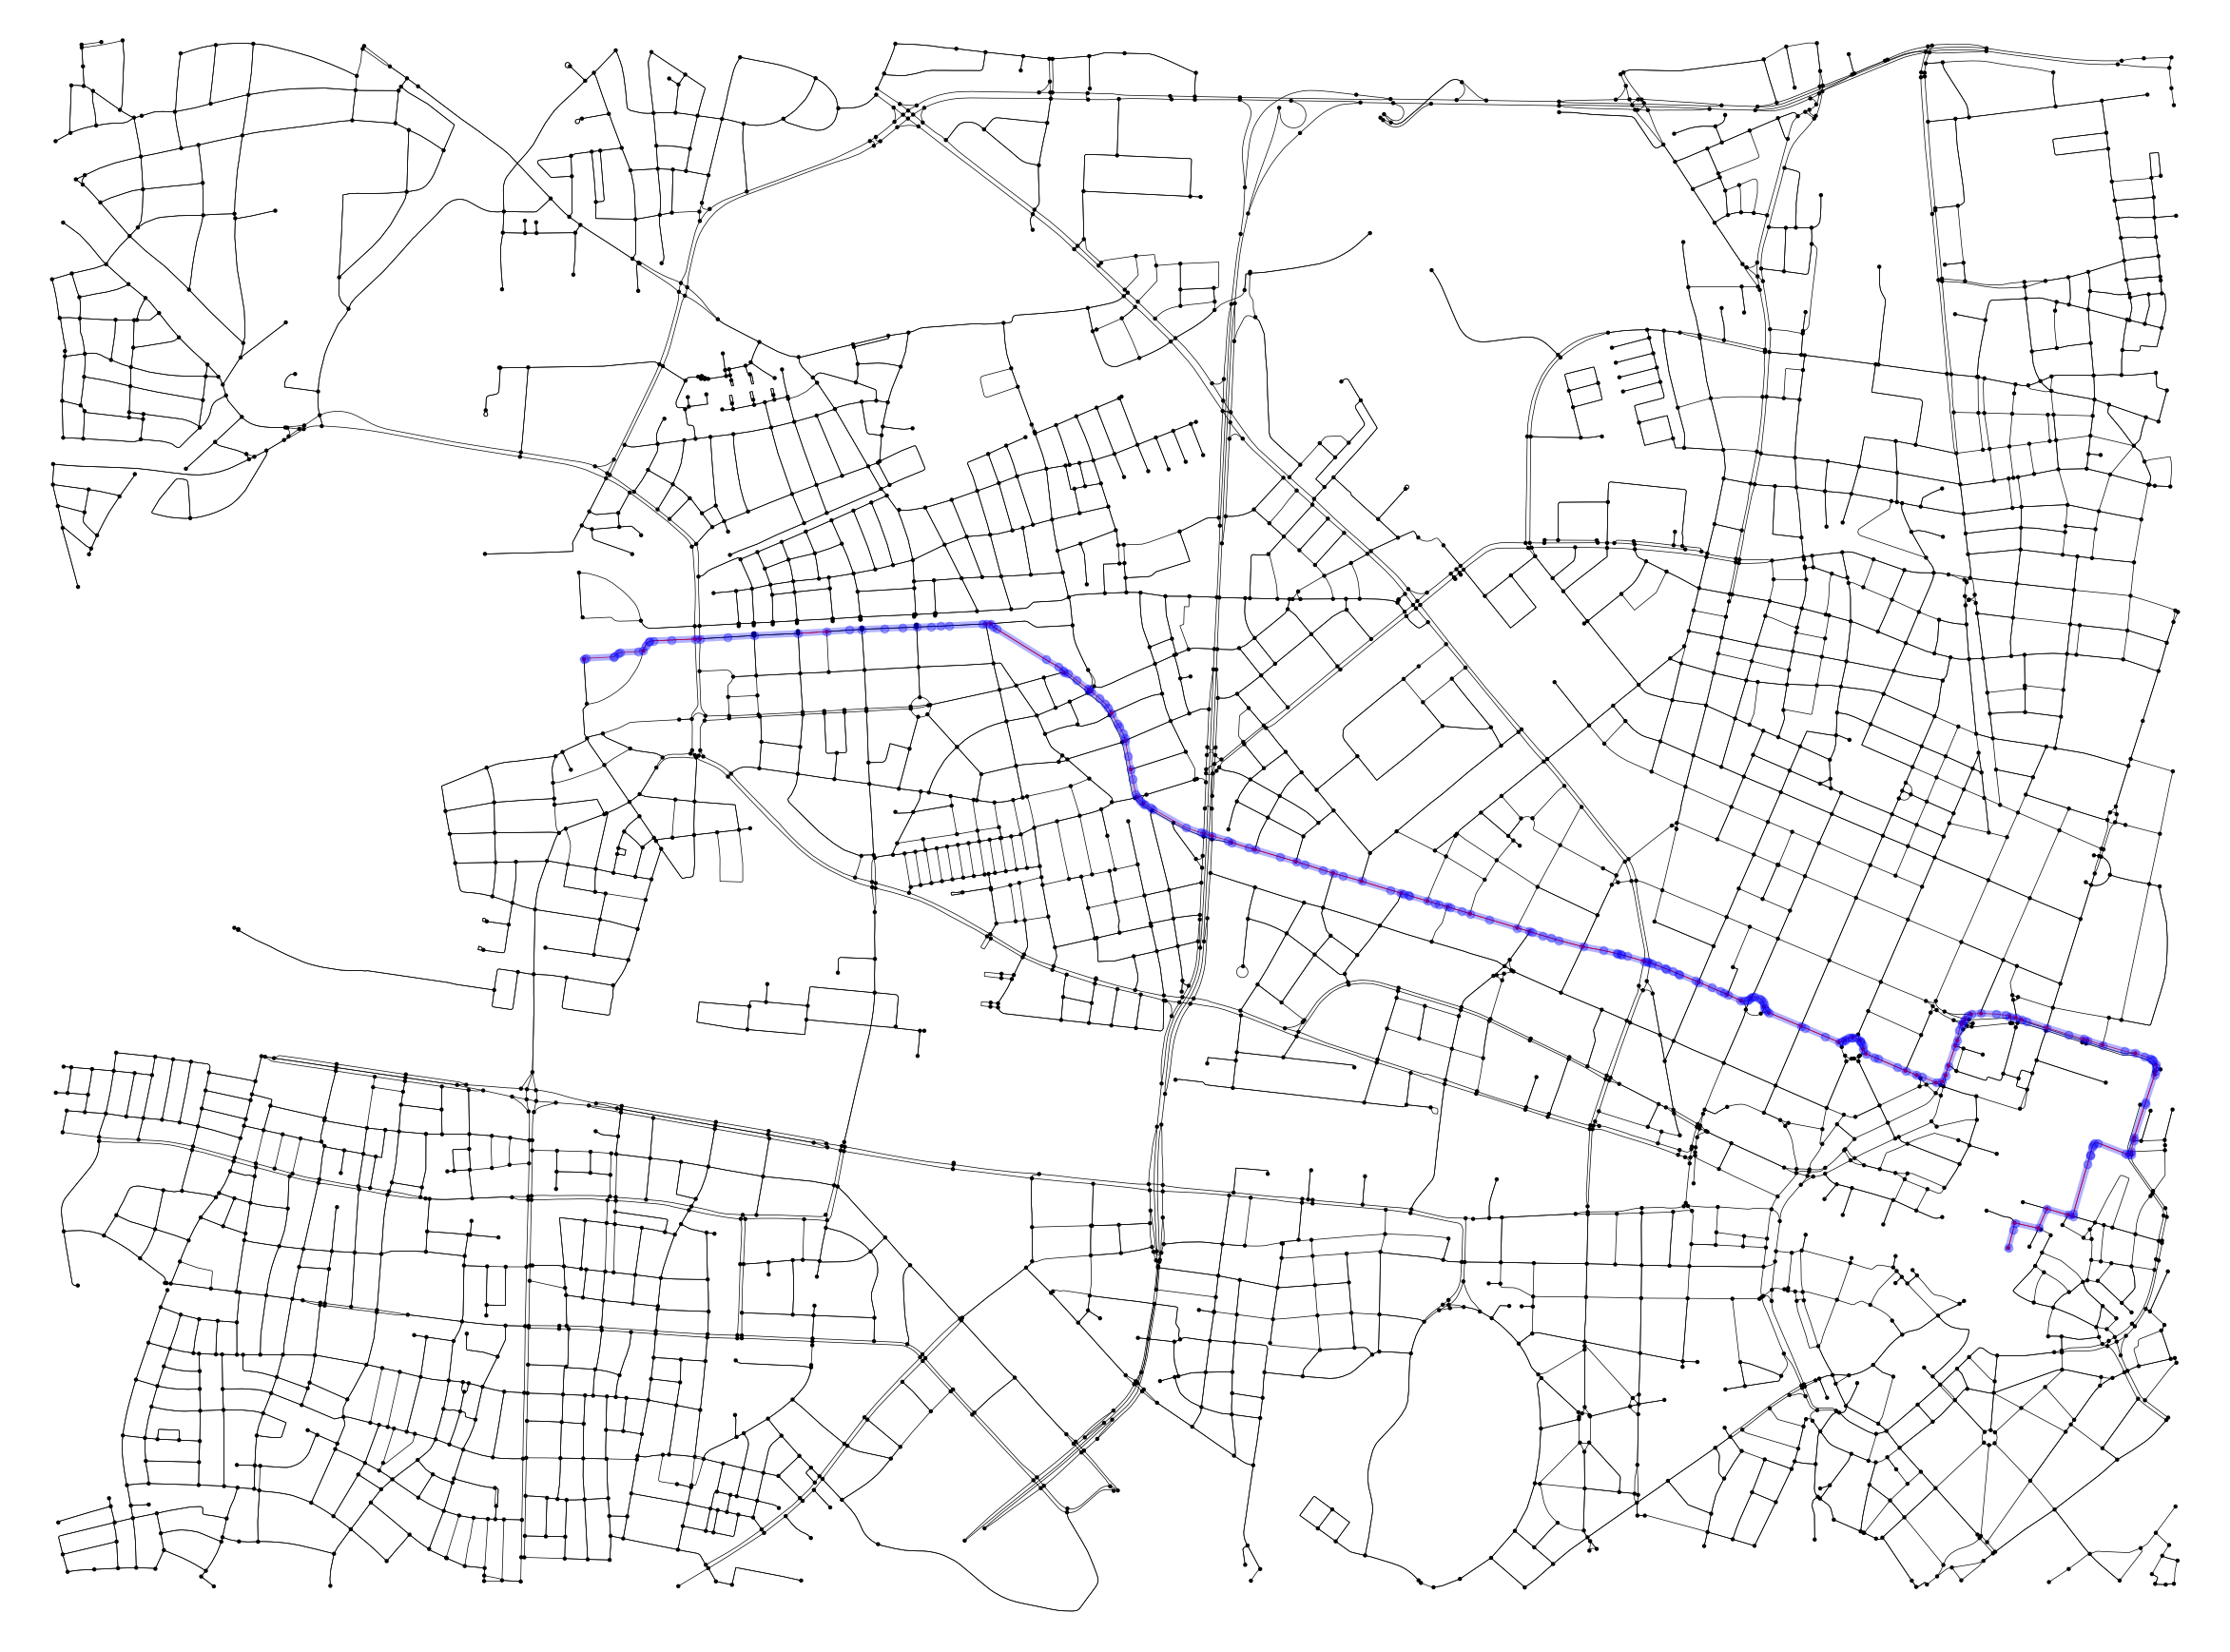

In [53]:
# route_edges = list(zip(route_nodes[:-1], route_nodes[1:]))

# node_colors, edge_colors = get_colors_by_accidents(munich_graph_accident)
def route_to_graph_node(route):
    nodes = []
    for coord in route:
        node, dist = ox.nearest_nodes(munich_graph_accident, X=coord[0], Y=coord[1],return_dist=True)
        if dist < 0.1:
            nodes.append(node)
        # graph.neighbors(start_node)
    return nodes

route_nodes = route_to_graph_node(route)
route_edges = list(zip(route_nodes[:-1], route_nodes[1:]))


edge_colors = ['red' if (u, v) in route_edges or (v, u) in route_edges else 'black' for u, v, k in munich_graph_accident.edges(keys=True)]
node_colors = ['red' if node in route_nodes else 'black' for node in munich_graph_accident.nodes()]

# Plot the graph
# fig, ax = ox.plot_graph(munich_graph_accident, node_color=node_colors, edge_color=edge_colors,figsize=(15, 15), node_size=10, edge_linewidth=1, show=False, close=False,bgcolor='black')

# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig, ax = ox.plot_graph(munich_graph_accident, node_color=node_colors, edge_color=edge_colors,figsize=(30, 30), node_size=10, edge_linewidth=0.5, show=False, close=False,bgcolor='white')

ax.plot([x[0] for x in route],[x[1] for x in route], c="blue", linewidth=5,zorder=4,alpha=0.3,marker='o')
fig.savefig('munich_projected_route.png', dpi=300)

In [191]:
route_edges = list(zip(route_nodes[1:-2], route_nodes[1:]))

route_edges



[(10657130620, 1955013),
 (1955013, 1955013),
 (1955013, 2545258030),
 (2545258030, 25274621),
 (25274621, 18954572),
 (18954572, 292940279),
 (292940279, 292940279),
 (292940279, 20982469),
 (20982469, 20982469),
 (20982469, 20982469),
 (20982469, 20982469),
 (20982469, 20982469),
 (20982469, 20982469),
 (20982469, 20982469),
 (20982469, 20982469),
 (20982469, 20982469),
 (20982469, 1788376009),
 (1788376009, 20982463),
 (20982463, 31863456),
 (31863456, 1788385804),
 (1788385804, 1582278230),
 (1582278230, 1582278230),
 (1582278230, 20982472),
 (20982472, 311237526),
 (311237526, 344335068),
 (344335068, 344335068),
 (344335068, 344335068),
 (344335068, 344335068),
 (344335068, 344335068),
 (344335068, 311237534),
 (311237534, 311237534),
 (311237534, 311237534),
 (311237534, 265086232),
 (265086232, 1002798325),
 (1002798325, 1002798321),
 (1002798321, 1002798321),
 (1002798321, 20982424),
 (20982424, 644630270),
 (644630270, 644630270),
 (644630270, 27487422),
 (27487422, 20982428)

In [158]:
def color_route(graph, route_nodes, color):
    for i,node in enumerate(route_nodes):
        graph.nodes[node]['color'] = color
        if 0 < i < len(route_nodes)-1:
            
            graph[route_nodes[i-1]][route_nodes[i]]['color'] = color
            
    return graph

munich_graph_accident = color_route(munich_graph_accident, route_nodes, 'blue')
color_edge = munich_graph_accident.edges['color']

# fig, ax = ox.plot_graph(munich_graph_accident, edge_color=graph.edges[color],figsize=(20, 20), node_size=10, edge_linewidth=0.5, show=False, close=False,bgcolor='black')


KeyError: 19094193

In [175]:
graph[route_nodes[1]][route_nodes[2]]

KeyError: 1955013

In [160]:
route_nodes[0]

19094193